In [15]:
import sys
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
sys.path.append('../src/')
from utils import *
from config import *

from matplotlib import rcParams
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.lines as mlines
import seaborn as sns
rcParams.update(fig_params)

from scipy import stats as stats
from scipy.stats import rv_continuous, rv_histogram, norm, beta, multivariate_normal
from sklearn.model_selection import train_test_split
from scipy.linalg import block_diag

from sklearn.datasets import fetch_openml
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Load Titanic dataset

Data description:

- Pclass - Passenger Class (1 = 1st; 2 = 2nd; 3 = 3rd)
- Sex - Sex
- Age - Age
- Sibsp - Number of Siblings/Spouses Aboard
- Parch - Number of Parents/Children Aboard
- Fare - Passenger Fare
- Embarked - Port of Embarkation (C = Cherbourg; Q = Queenstown; S = Southampton)
- Survived - If they survived the shipwreck (0 = No; 1 = Yes)

In [16]:
X, y = fetch_openml("titanic", version=1, as_frame=True, return_X_y=True)

# Features that we will use
numericals = ['age', 'sibsp', 'parch', 'fare']
categoricals = ['pclass', 'sex', 'embarked']
features = numericals + categoricals
target = 'survived'
X = X[features].copy()
y = y.astype(int)

comb = pd.concat([X, y.to_frame()], axis=1)
comb.head()

,age,sibsp,parch,fare,pclass,sex,embarked,survived
0,29.0000,0.0,0.0,211.3375,1.0,female,S,1
1,0.9167,1.0,2.0,151.5500,1.0,male,S,1
2,2.0000,1.0,2.0,151.5500,1.0,female,S,0
3,30.0000,1.0,2.0,151.5500,1.0,male,S,0
4,25.0000,1.0,2.0,151.5500,1.0,female,S,0


In the next cell we generate a totally random categorical features with $L$ categories and with no correlation with the target variable.

In [3]:
seed_everything(seed=42)
L = 2

comb['random_cat'] = np.random.randint(L, size=comb.shape[0])
categoricals += ['random_cat']
features = numericals + categoricals
comb

,age,sibsp,parch,fare,pclass,sex,embarked,survived,random_cat
0,29.0000,0.0,0.0,211.3375,1.0,female,S,1,0
1,0.9167,1.0,2.0,151.5500,1.0,male,S,1,1
2,2.0000,1.0,2.0,151.5500,1.0,female,S,0,0
3,30.0000,1.0,2.0,151.5500,1.0,male,S,0,0
4,25.0000,1.0,2.0,151.5500,1.0,female,S,0,0
...,...,...,...,...,...,...,...,...,...
1304,14.5000,1.0,0.0,14.4542,3.0,female,C,0,1
1305,NaN,1.0,0.0,14.4542,3.0,female,C,0,0
1306,26.5000,0.0,0.0,7.2250,3.0,male,C,0,1
1307,27.0000,0.0,0.0,7.2250,3.0,male,C,0,1


## Preprocessing

In [5]:
# Fillna with mean value
comb['age'].fillna(comb['age'].mean(), inplace=True)
comb['fare'].fillna(comb['fare'].mean(), inplace=True)

# Label encoding of the categorical features
comb[categoricals] = (comb[categoricals].apply(lambda x: pd.factorize(x)[0]))

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(comb[features], comb[target], stratify=comb[target], random_state=42)

## Training and evaluation

In [6]:
model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [7]:
print(f'RF train accuracy: {model.score(X_train, y_train):.3f}')
print(f'RF test accuracy: {model.score(X_test, y_test):.3f}')

RF train accuracy: 0.984
RF test accuracy: 0.805


## Feature importance (MDI)

In [8]:
model.feature_importances_.round(6)

array([0.26877 , 0.049189, 0.045586, 0.270121, 0.070622, 0.227986,
       0.037775, 0.02995 ])

In [9]:
model[99].feature_importances_

array([0.24430842, 0.04857086, 0.02438241, 0.31382783, 0.04993705,
       0.26364868, 0.03219444, 0.02313031])

In [10]:
mdi_df = pd.DataFrame(data=[model[i].feature_importances_ for i in range(model.n_estimators)], columns=features).agg(['mean', 'std'])
mdi_df = mdi_df.T.sort_values(by='mean', ascending=False)
mdi_df

,mean,std
fare,0.270121,0.045383
age,0.268770,0.028688
sex,0.227986,0.045968
pclass,0.070622,0.029444
sibsp,0.049189,0.017108
parch,0.045586,0.014472
embarked,0.037775,0.011235
random_cat,0.029950,0.012570


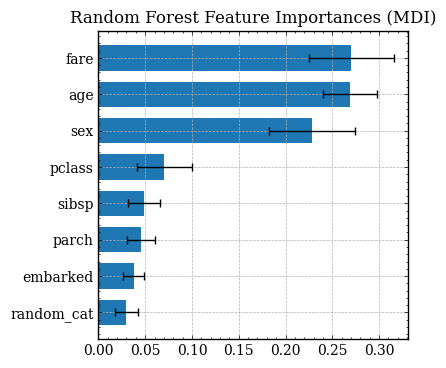

In [11]:
fig, ax = plt.subplots(figsize=(4,4))
ax.barh(y=mdi_df.index.values, height=0.7, width=mdi_df['mean'].values, xerr=mdi_df['std'].values, capsize=3)
ax.set_title('Random Forest Feature Importances (MDI)')
plt.gca().invert_yaxis()

## Simulation

### Sensitivity to number of classes in random categorical column

In [12]:
L_list = [5, 10, 50, 100, 500, 1000]

In [13]:
seed_everything(seed=42)

results = {}

for L in tqdm(L_list):
    results[L] = {}
    # Load dataset
    X, y = fetch_openml("titanic", version=1, as_frame=True, return_X_y=True)
    # Features that we will use
    numericals = ['age', 'sibsp', 'parch', 'fare']
    categoricals = ['pclass', 'sex', 'embarked']
    features = numericals + categoricals
    target = 'survived'
    X = X[features].copy()
    y = y.astype(int)

    comb = pd.concat([X, y.to_frame()], axis=1)
    # Create random categorical column
    comb['random_cat'] = np.random.randint(L, size=comb.shape[0])
    categoricals += ['random_cat']
    features = numericals + categoricals
    
    # Fillna with mean value
    comb['age'].fillna(comb['age'].mean(), inplace=True)
    comb['fare'].fillna(comb['fare'].mean(), inplace=True)

    # Label encoding of the categorical features
    comb[categoricals] = (comb[categoricals].apply(lambda x: pd.factorize(x)[0]))

    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(comb[features], comb[target], stratify=comb[target], random_state=42)
    
    # Training
    model = RandomForestClassifier(random_state=42)
    model.fit(X_train, y_train)
    
    # Feature importance
    mdi_df = pd.DataFrame(data=[model[i].feature_importances_ for i in range(model.n_estimators)], columns=features).agg(['mean', 'std'])
    mdi_df = mdi_df.T.sort_values(by='mean', ascending=False)
    
    # Persist results
    results[L]['acc_train'] = model.score(X_train, y_train)
    results[L]['acc_test'] = model.score(X_test, y_test)
    results[L]['importances'] = mdi_df

  0%|          | 0/6 [00:00<?, ?it/s]

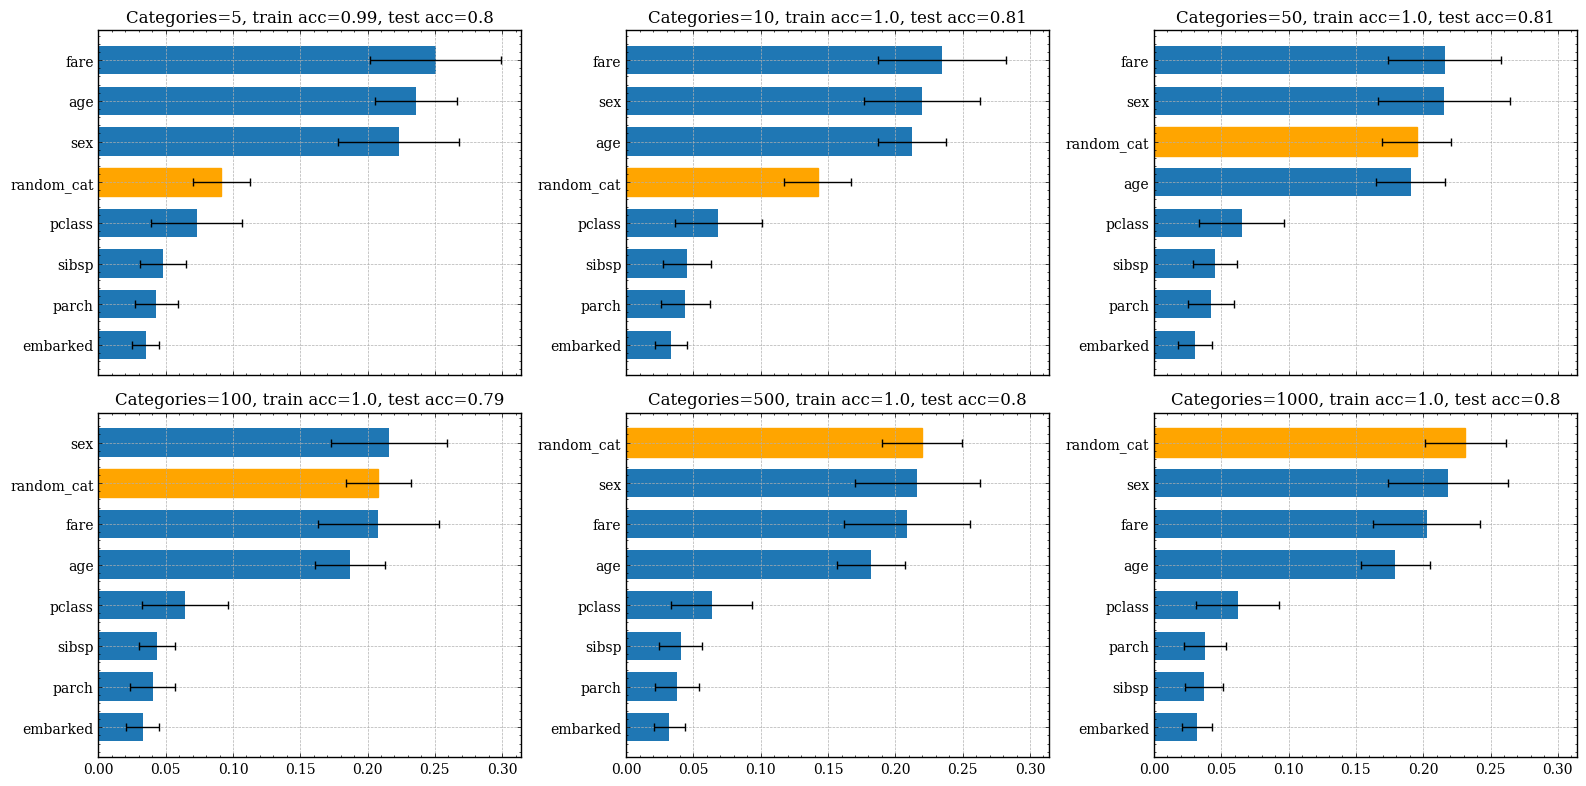

In [14]:
fig, axes = plt.subplots(2, 3, figsize=(16,8), sharex=True)
axes = axes.reshape(2*3)
for i, (L,res) in enumerate(results.items()):
    mdi_df = results[L]['importances'].copy()
    barplot = axes[i].barh(y=mdi_df.index.values, height=0.7, width=mdi_df['mean'].values, xerr=mdi_df['std'].values, capsize=3)
    rnd_cat_idx = mdi_df.index.get_loc('random_cat')
    barplot[rnd_cat_idx].set_color('orange')
    axes[i].set_title('Categories={0}, train acc={1}, test acc={2}'.format(L, results[L]['acc_train'].round(2), results[L]['acc_test'].round(2)))
    axes[i].invert_yaxis()
plt.tight_layout()

## References

https://scikit-learn.org/stable/auto_examples/inspection/plot_permutation_importance.html#sphx-glr-auto-examples-inspection-plot-permutation-importance-py